# Ocean Circulation Diagnostics

### Import modules

In [1]:
import sys
sys.path.insert(0, '../..')

%load_ext autoreload
%autoreload 2
from aqua import Reader,catalogue, inspect_catalogue
from ocean3d import plot_stratification
from ocean3d import plot_spatial_mld_clim
from aqua.util import load_yaml

### Model Data import

This block is to load the data of a model (chosen from the catalog as an example )


In [2]:
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")
data = reader.retrieve()

data = data.rename({"nz1":"lev"}) # We standardise the name for the vertical dimension
data = data[["ocpt","so"]].resample(time="MS").mean() # And we keep only the relevant variables in the dataset

## Functions:

All functions (primary and secondary) can be found in ocean_circulation
The two primary diagnostic functions are:

### 1. plot_stratification

`plot_stratification(mod_data, region=None, time = None, latS:   float=None, latN: float=None, lonW: float=None,lonE: float=None, output= bool, output_dir="./figs")`

This function produces climatological stratification plots over a region in a model dataset and EN4 observations. It produces three lines, one for the whole model simulation, one for the model in the overlap period with EN4, and another for EN4 in the overlap period with the model. If there is no overlap period with observations, EN4 climatology is provided for the period 1950-2022.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- A specific region where stratification is computed (or to provide a custom latxlon box instead)
- The temporal resolution over which the climatology is computed (annual, a given season or a given month). 
     
### 2. plot_spatial_mld

`plot_spatial_mld(data, region=None, time = None, overlap = bolean latS: float=None, latN: float=None, lonW: float=None,lonE: float=None, output= bool, output_dir="./figs")`

This function computes the mixed layer depth from monthly 3D ocean potential temperature and practical salinity, both for a model simulation and EN4 observations, and plots their climatology. It allows the user to choose if climatologies
are computed over the whole simulated and observed period, or over their overlap periods.

It requires you to provide:
- A file with model data of 3D ocean potential temperature and practical salinity
- A specific latitudinal/longitudinal box over which the MLD is shown
- The temporal resolution over which the climatology is computed (annual, a given season or a given month)

## Example

In [3]:
import os
output_dir = os.path.expanduser("~/AQUA_output") # It can also be costumized by the user
# output_dir = "/work/bb1153/b382397/AQUA_output"
# output_dir = "/home/b/b382075/work/de340_7.1.2/ocean_3d"  #Deliverable Dir
print(output_dir)

/home/b/b382119/AQUA_output


To plot the climatological Labrador Sea stratification in January and DJF we would use plot_stratification as shown below

2023-07-18 09:58:00,323 - INFO - loaded EN4 data
2023-07-18 09:58:00,378 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 09:58:00,379 - INFO - Selected for this region (latitude 52.0 to 65.0, longitude 300.0 to 316.0)
2023-07-18 09:58:00,463 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:58:00,647 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:58:01,016 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 09:58:01,048 - INFO - data selected for february climatology
2023-07-18 09:58:01,049 - INFO - Selected for this region (latitude 52.0 to 65.0, longitude 300.0 to 316.0)
2023-07-18 09:58:01,085 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:58:01,155 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:58:01,287 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 09

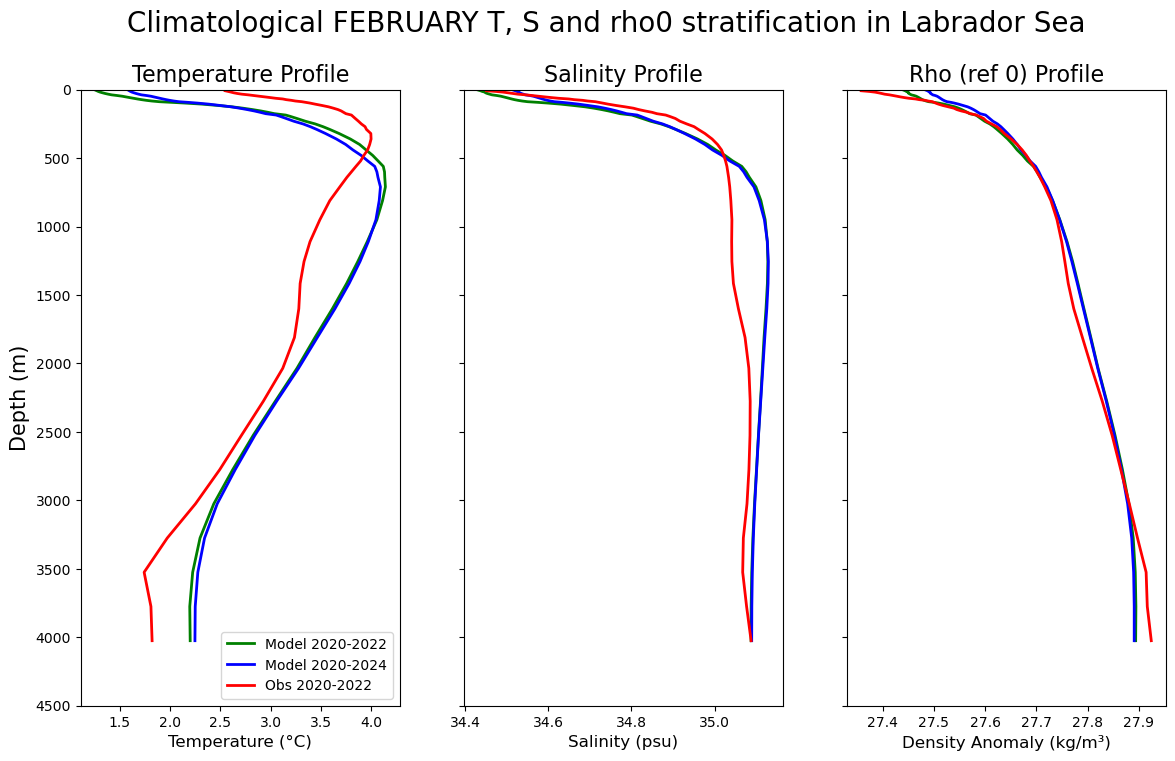

2023-07-18 09:58:15,886 - INFO - loaded EN4 data
2023-07-18 09:58:15,922 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 09:58:15,922 - INFO - Selected for this region (latitude 52.0 to 65.0, longitude 300.0 to 316.0)
2023-07-18 09:58:15,976 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:58:16,101 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:58:16,358 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 09:58:16,383 - INFO - data selected for djf climatology
2023-07-18 09:58:16,383 - INFO - Selected for this region (latitude 52.0 to 65.0, longitude 300.0 to 316.0)
2023-07-18 09:58:16,411 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:58:16,464 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:58:16,566 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 09:58:1

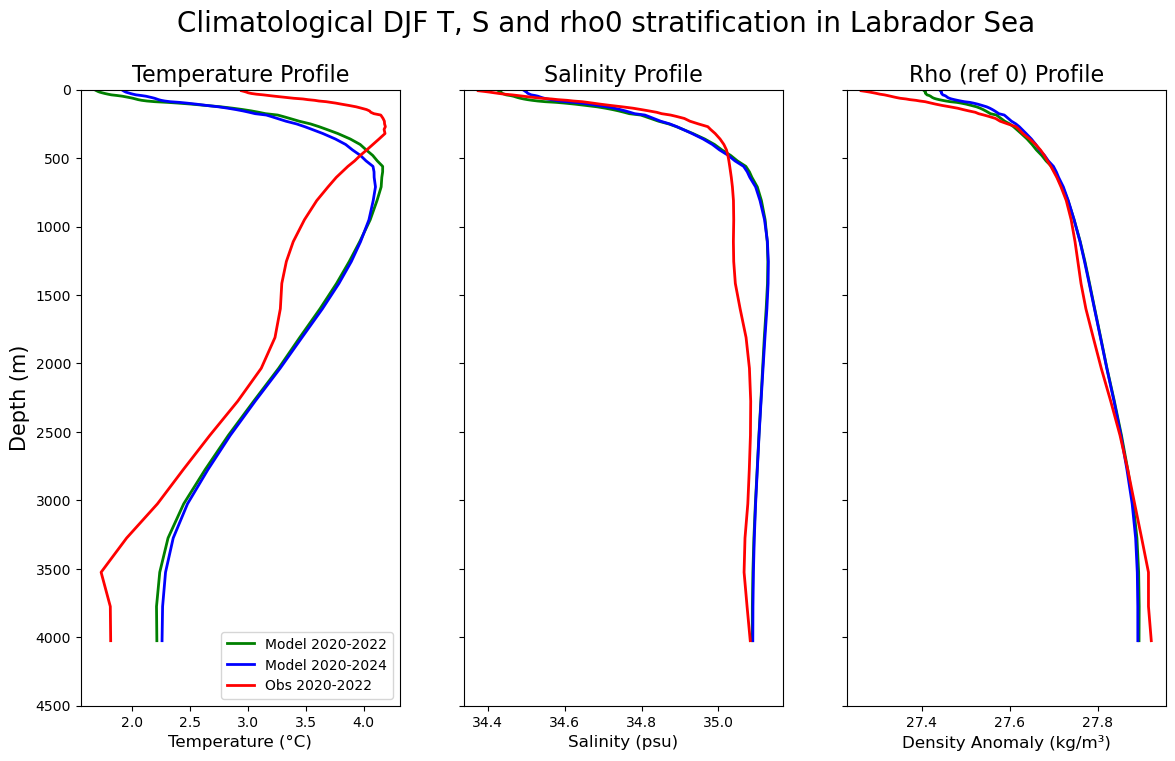

In [4]:
plot_stratification(data, region= "Labrador Sea", time = "February",output= True, output_dir= output_dir)
plot_stratification(data, region= "Labrador Sea", time = "DJF",output= True, output_dir= output_dir)

To plot the climatological MLD in march, fma or the whole year in the Labrador and GIN Seas in all cases 
for the overlap period of the Model and Obs datasets we would call plot_spatial_mld_clim as shown below


2023-07-18 09:59:00,779 - INFO - loaded EN4 data
2023-07-18 09:59:00,787 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 09:59:00,790 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 09:59:00,796 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-18 09:59:00,799 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:59:00,866 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:59:00,987 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 09:59:01,091 - INFO - data selected for mar climatology
2023-07-18 09:59:01,108 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-18 09:59:01,114 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:59:01,248 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:59:01,51

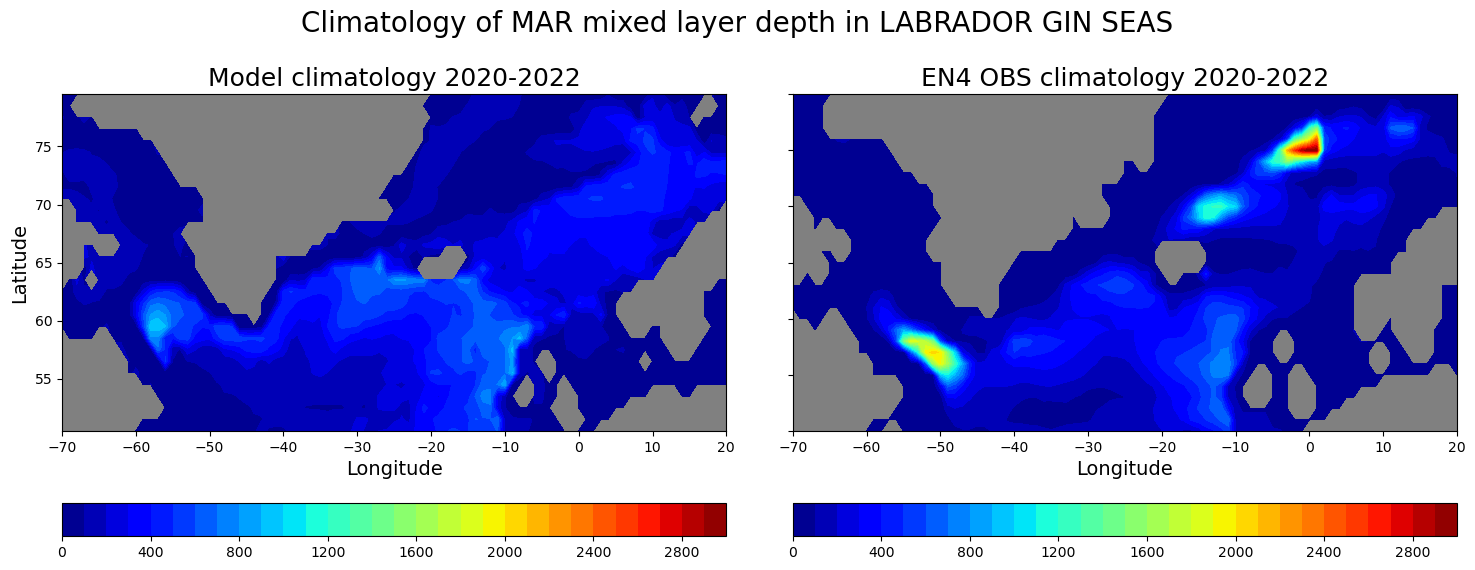

2023-07-18 09:59:11,742 - INFO - loaded EN4 data
2023-07-18 09:59:11,751 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 09:59:11,754 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 09:59:11,759 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-18 09:59:11,762 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:59:11,830 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:59:11,948 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 09:59:12,060 - INFO - data selected for fma climatology
2023-07-18 09:59:12,079 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-18 09:59:12,084 - INFO - practical salinity converted to absolute salinity
2023-07-18 09:59:12,222 - INFO - potential temperature converted to conservative temperature
2023-07-18 09:59:12,48

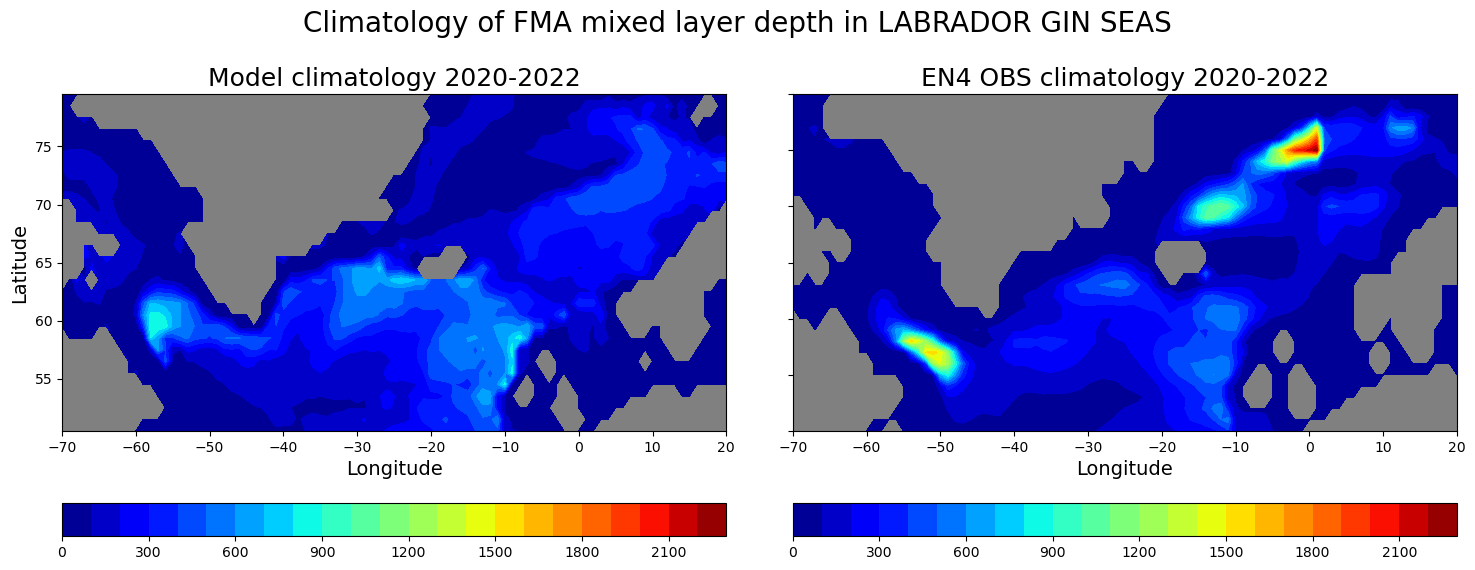

In [5]:
plot_spatial_mld_clim(data, region= "labrador_gin_seas", time = "Mar",overlap= True,output= True, output_dir= output_dir)
plot_spatial_mld_clim(data, region= "labrador_gin_seas", time = "FMA",overlap= True,output= True, output_dir= output_dir)

This is an example of how to call thee same function but for the overlap period between OBS and the model, and using yearly means

2023-07-15 18:36:55,832 - INFO - loaded EN4 data
2023-07-15 18:36:55,840 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-15 18:36:55,842 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-15 18:36:55,849 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-15 18:36:55,851 - INFO - practical salinity converted to absolute salinity
2023-07-15 18:36:55,911 - INFO - potential temperature converted to conservative temperature
2023-07-15 18:36:56,023 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-15 18:36:56,446 - INFO - data selected for y climatology
2023-07-15 18:36:56,463 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-15 18:36:56,468 - INFO - practical salinity converted to absolute salinity
2023-07-15 18:36:56,597 - INFO - potential temperature converted to conservative temperature
2023-07-15 18:36:56,863 

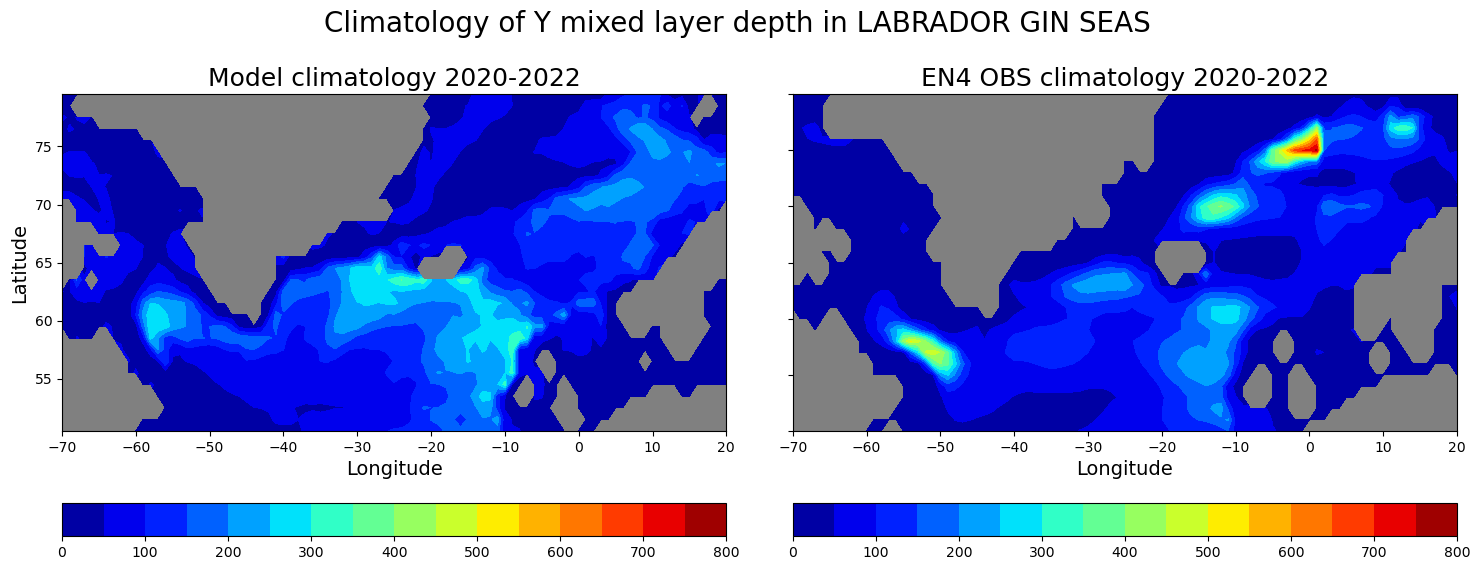

In [44]:
plot_spatial_mld_clim(data, region= "labrador_gin_seas", time = "Y",overlap= True,output= True, output_dir= output_dir)


This is an equivalent example but not producing the average for the whole temporal extent of OBS and the model datasets

2023-07-18 10:18:33,474 - INFO - loaded EN4 data
2023-07-18 10:18:33,486 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-18 10:18:33,495 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:18:33,584 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:18:33,746 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 10:18:33,958 - INFO - data selected for year climatology
2023-07-18 10:18:34,032 - INFO - Selected for this region (latitude 50.0 to 80.0, longitude -70.0 to 20.0)
2023-07-18 10:18:34,043 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:18:34,258 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:18:34,695 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 10:18:39,308 - INFO - data selected for year climatology
2023-07-18 10:18:39,386 - INFO - Spatial MLD plot

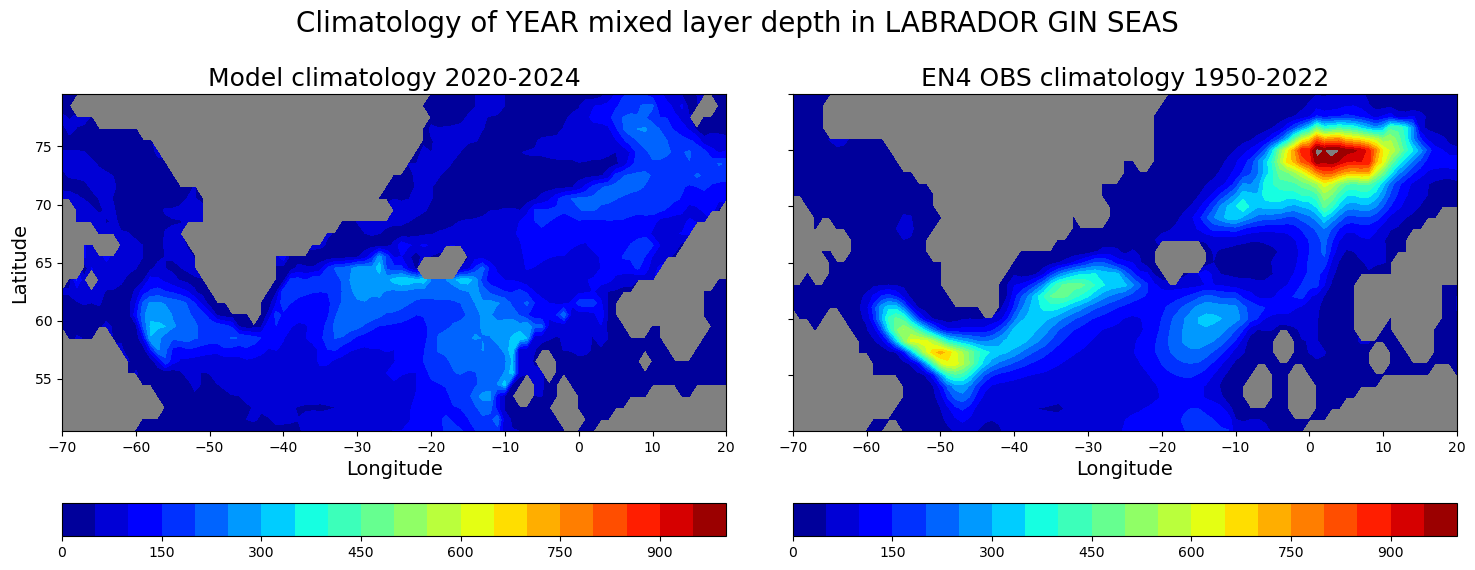

In [14]:
plot_spatial_mld_clim(data, region= "labrador_gin_seas", time = "Year",overlap= False,output= True, output_dir= output_dir)

This example is for computing stratification in the Weddell Sea in the boreal winter (JJA)


2023-07-18 10:04:36,660 - INFO - loaded EN4 data
2023-07-18 10:04:36,670 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 10:04:36,674 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 10:04:36,674 - INFO - Selected for this region (latitude -80.0 to -65.0, longitude 295.0 to 350.0)
2023-07-18 10:04:36,678 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:04:36,768 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:04:36,928 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 10:04:37,080 - INFO - data selected for jja climatology
2023-07-18 10:04:37,088 - INFO - Selected for this region (latitude -80.0 to -65.0, longitude 295.0 to 350.0)
2023-07-18 10:04:37,095 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:04:37,296 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:04

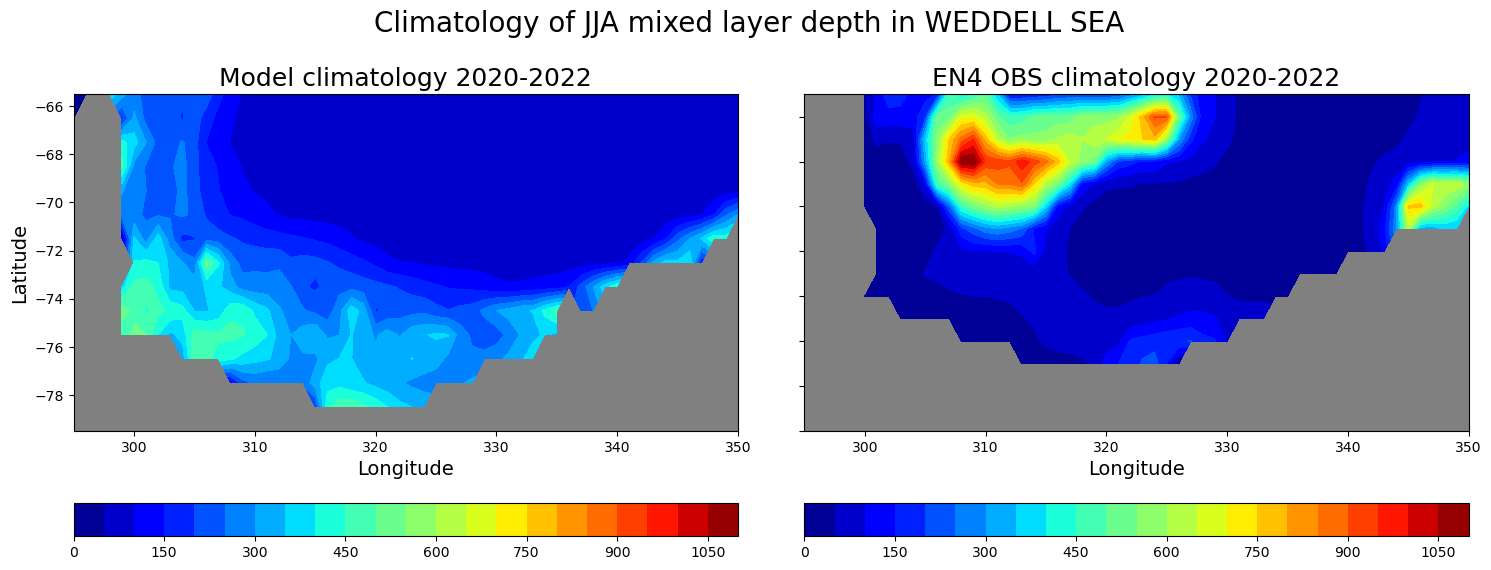

In [12]:
plot_spatial_mld_clim(data, region= "weddell sea", time = "jja",overlap= True, output= True, output_dir= output_dir)

This would be the equivalent plot but for the ocean stratification in the same region and time of the year

2023-07-18 10:04:56,642 - INFO - loaded EN4 data
2023-07-18 10:04:56,700 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 10:04:56,701 - INFO - Selected for this region (latitude -80.0 to -65.0, longitude 295.0 to 350.0)
2023-07-18 10:04:56,786 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:04:56,974 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:04:57,363 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 10:04:57,398 - INFO - data selected for jja climatology
2023-07-18 10:04:57,399 - INFO - Selected for this region (latitude -80.0 to -65.0, longitude 295.0 to 350.0)
2023-07-18 10:04:57,436 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:04:57,511 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:04:57,648 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 10:

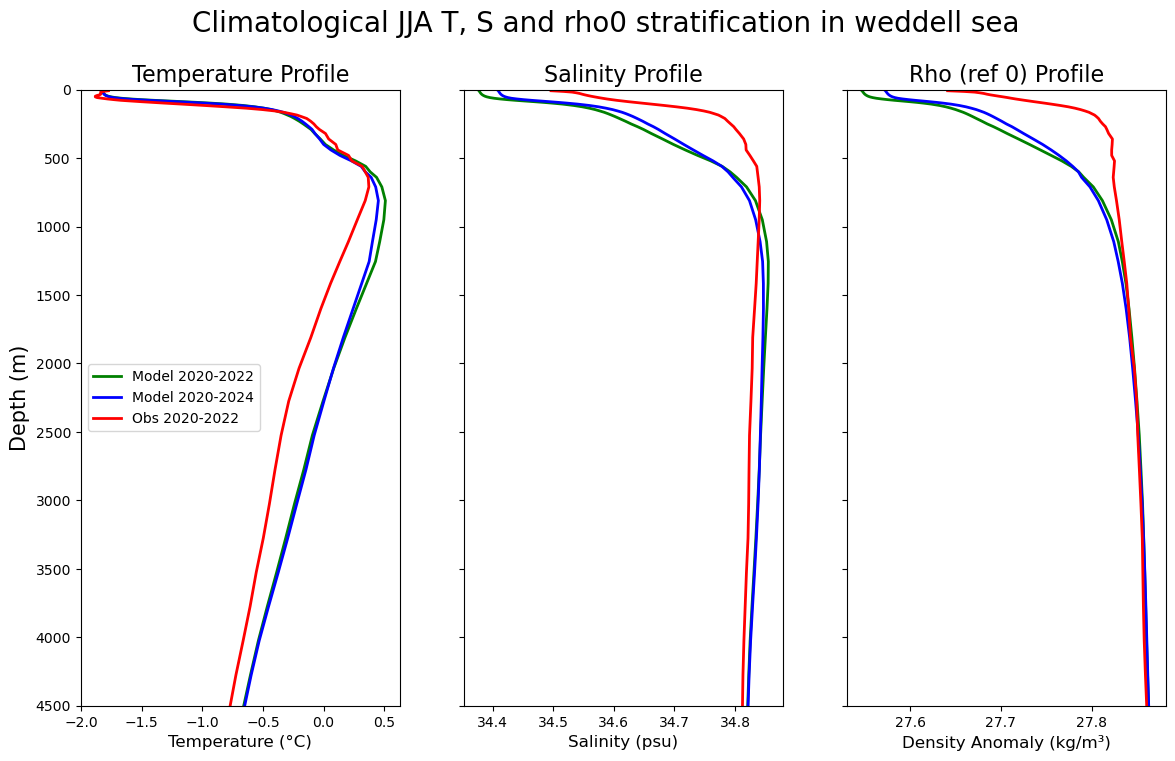

In [13]:
plot_stratification(data, region= "weddell sea",time = "JJA", output= True, output_dir= output_dir)

This final example plots MLD climatology in the southern ocean in the austral winter (JJA) over the overlap period of OBS/MODEL

2023-07-18 10:00:30,190 - INFO - loaded EN4 data
2023-07-18 10:00:30,205 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 10:00:30,208 - INFO - selected the overlaped time of the obs data compare to the model
2023-07-18 10:00:30,209 - INFO - Selected for this region (latitude -80.0 to -50.0, longitude 0.0 to 360.0)
2023-07-18 10:00:30,212 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:00:30,298 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:00:30,458 - INFO - Calculated potential density in-situ at reference pressure 0 dbar 
2023-07-18 10:00:30,610 - INFO - data selected for jja climatology
2023-07-18 10:00:30,617 - INFO - Selected for this region (latitude -80.0 to -50.0, longitude 0.0 to 360.0)
2023-07-18 10:00:30,626 - INFO - practical salinity converted to absolute salinity
2023-07-18 10:00:30,827 - INFO - potential temperature converted to conservative temperature
2023-07-18 10:00:31,

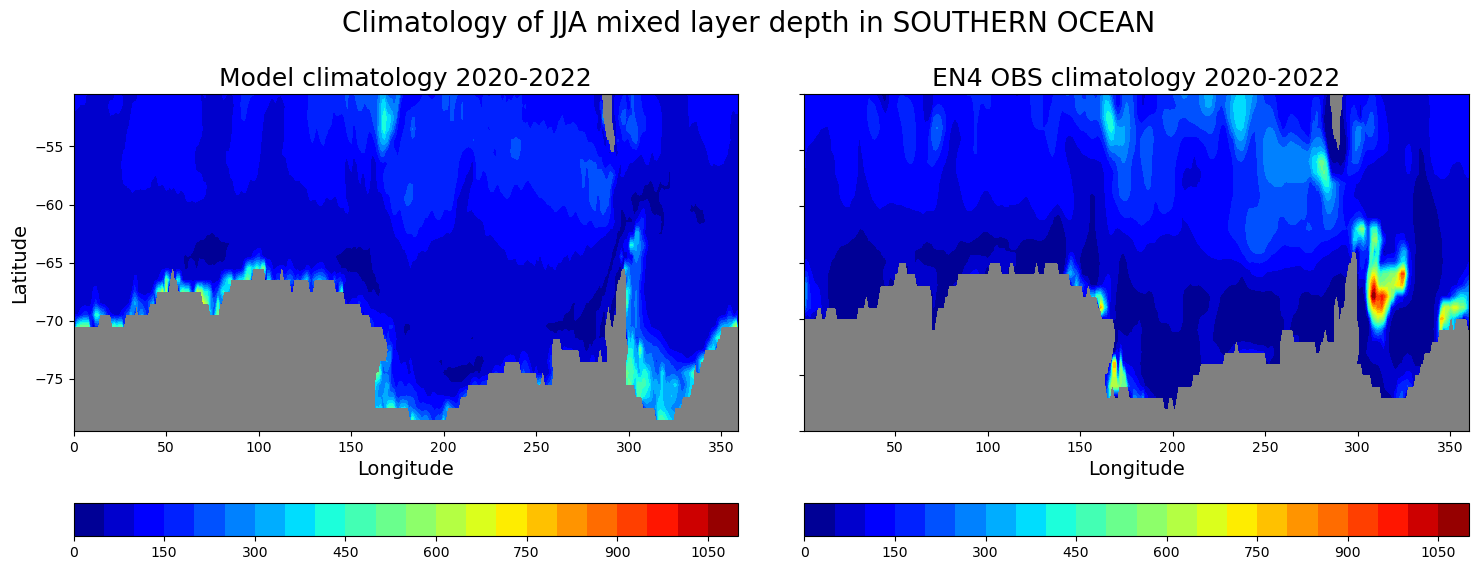

In [8]:
plot_spatial_mld_clim(data, region= "southern ocean",time = "JJA",overlap= True, output= True, output_dir= output_dir)